In [1]:
# import package
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Arial'

In [ ]:
# load the data
result_refseq = pickle.load(open("refseq.pkl", "rb"))
result_discover = pickle.load(open("result.pkl", "rb"))
result_ec = pickle.load(open("ec.pkl", "rb"))

In [2]:
# retrieve data
repr_refseq = result_refseq["representations"]
repr_discover = result_discover["representations"]
repr_ec = result_ec["representations"]

label_refseq = result_refseq["labels"]
label_discover = result_discover["labels"]
label_ec = result_ec["labels"]

sequence_refseq = result_refseq["sequences"]
sequence_discover = result_discover["sequences"]
sequence_ec = result_ec["sequences"]

# data_refseq = pd.read_csv("../refseq/refseq_lysozyme.csv")
data_ec = pd.read_csv("ec_dataset.csv")

print("Size of reference sequence: ", repr_refseq.shape)
print("Size of found sequence: ", repr_discover.shape)
print("Size of EC sequence: ", repr_ec.shape)


Size of reference sequence:  (93, 1024)
Size of found cluster1 sequence:  (117896, 1024)
Size of found cluster2 sequence:  (197536, 1024)
Size of found cluster34 sequence:  (176554, 1024)
Size of EC sequence:  (264572, 1024)


In [3]:
# calculate distance to reference
def distance_to_reference(repr, ref):
    return np.min(np.linalg.norm(repr - ref, axis=1))   # Euclidean distance
    # return np.min(np.sum(np.abs(repr - ref), axis=1))   # Manhattan distance
    # return np.min(np.dot(repr, ref) / (np.linalg.norm(repr) * np.linalg.norm(ref)))  # Cosine similarity


ref = repr_refseq


# cluster1
distance_to_ref_discover = []
full_length_discover = repr_discover.shape[0]
for i in range(full_length_discover):
    distance_to_ref_discover.append(distance_to_reference(repr_discover[i], ref))
    print("\r{}/{}".format(i, full_length_discover), end="")
print()
print("Finished Cluster 1")

# EC
distance_to_ref_ec = []
full_length_ec = repr_ec.shape[0]
for i in range(full_length_ec):
    distance_to_ref_ec.append(distance_to_reference(repr_ec[i], ref))
    print("\r{}/{}".format(i, full_length_ec), end="")
print()
print("Finished EC")

117895/117896
Finished Cluster 1
197535/197536
Finished Cluster 2
176553/176554
Finished Cluster 34
264571/264572
Finished EC


In [4]:
top_n_threshold = 4000
top_n_threshold_ec = 100

merge_repr_discover = np.concatenate([repr_refseq, repr_discover[np.argsort(distance_to_ref_discover)[0:top_n_threshold]], repr_ec[np.argsort(distance_to_ref_ec)[0:top_n_threshold_ec]]])
merge_label_discover = np.concatenate([label_refseq, np.array(label_discover)[np.argsort(distance_to_ref_discover)[0:top_n_threshold]], np.array(label_ec)[np.argsort(distance_to_ref_ec)[0:top_n_threshold_ec]]])
print(merge_repr_discover.shape)


(4193, 1024)
(4193, 1024)
(4193, 1024)


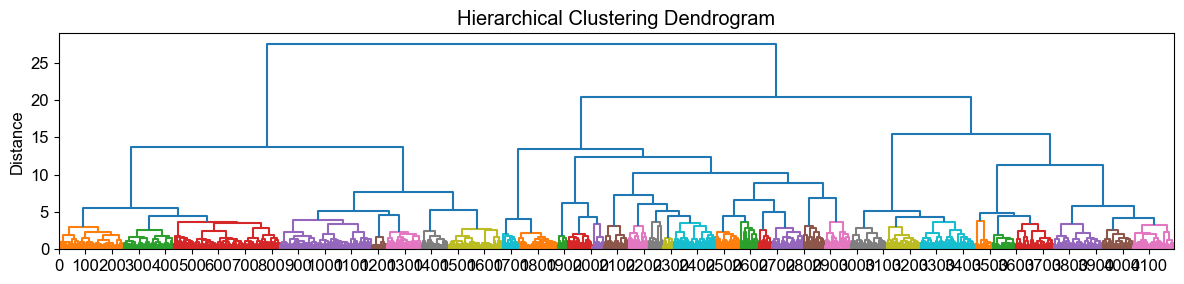

In [5]:
# hierarchical clustering
distance_matrix_discover = pdist(merge_repr_discover, metric='euclidean')
linkage_matrix_discover = linkage(distance_matrix_discover, method='ward')   # 'ward' is a method that minimizes the variance of clusters being merged.
hierarchal_cluster = fcluster(linkage_matrix_discover, 4, criterion='distance')

# create a dendrogram, but not show it
plt.figure(figsize=(12, 3))
tree_dict_discover = dendrogram(linkage_matrix_discover, color_threshold=4, no_labels=True)


plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.xticks(np.arange(0, merge_repr_discover.shape[0]*10, 1000), np.arange(0, merge_repr_discover.shape[0], 100))
plt.tight_layout()
plt.show()



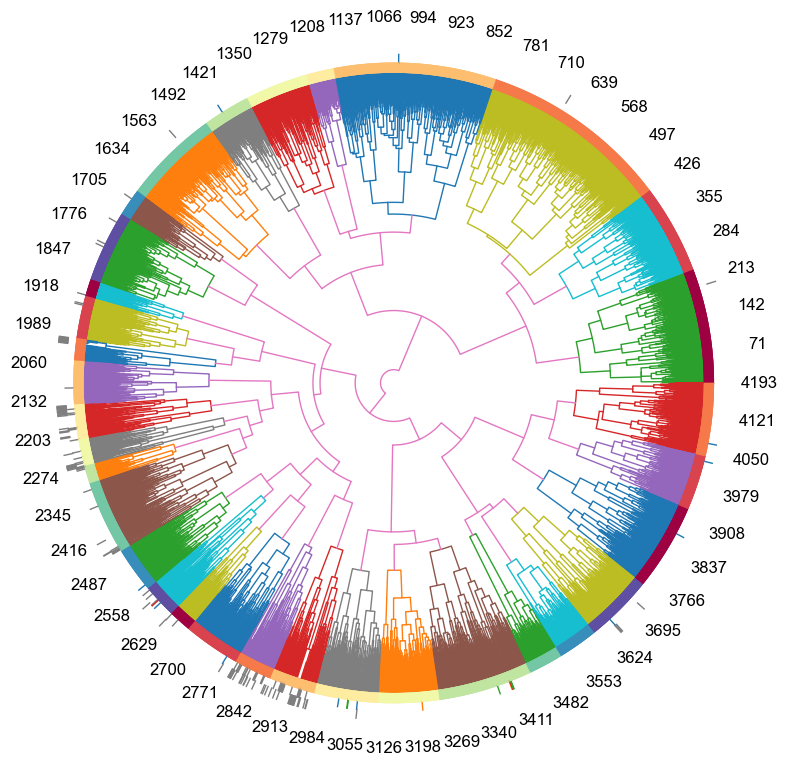

In [6]:
icoord = np.array(tree_dict_discover['icoord'])
dcoord = np.array(tree_dict_discover['dcoord'])
color_list = tree_dict_discover['color_list']
color_collection = list(set(color_list))


def smoothsegment(seg, Nsmooth=100):
    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

dcoord = -np.log(dcoord+1)
# avoid a wedge over the radial labels
gap = 0.0
imax = icoord.max()
imin = icoord.min()
icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi


plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True, rlabel_position=0)


for i in range(len(icoord)):
    xs = smoothsegment(icoord[i])
    ys = smoothsegment(dcoord[i])
    plt.plot(xs,ys, color=plt.cm.tab10_r((color_collection.index(color_list[i]))/(len(color_collection)-1)), linewidth=1, zorder=0)



index2rad = np.pi*2/len(tree_dict_discover["leaves"])
leave_index_list = tree_dict_discover["leaves"]
for i in range(len(leave_index_list)):
    leave_index = leave_index_list[i]
    rad = i*index2rad
    if leave_index < repr_refseq.shape[0]:        
        plt.plot([rad, rad], 
                 [0.1, 0.2], 
                 color="tab:green", linewidth=1, zorder=5)
    elif leave_index >= repr_refseq.shape[0] + top_n_threshold:  # from EC
        target_ec = "0.0.0.0"
        contain_target_ec = target_ec in data_ec[data_ec["UniProt_ID"]==merge_label_discover[leave_index]]["EC"].values

        if contain_target_ec:
            plt.plot([rad, rad], 
                     [0.2, 0.3], 
                     color="tab:green", linewidth=1, zorder=5)
        else:
            plt.plot([rad, rad], 
                     [0.2, 0.3], 
                     color="tab:grey", linewidth=1, zorder=5)
    else:
        pass

    plt.plot([rad, rad], 
             [0.0, 0.1], 
             color=plt.cm.Spectral((hierarchal_cluster[leave_index]-1)%10/9), linewidth=1, zorder=5)




plt.ylim(-3.5,0.4)
plt.grid(False)
plt.xticks(np.linspace(0, 2*np.pi, 60), [" "]+["%d"%x for x in np.linspace(0, len(leave_index_list), 60)][1:])
plt.yticks([])
# plt.axis('off')
plt.tight_layout()


# set the x axis invisible
plt.gca().spines['polar'].set_visible(False)

plt.savefig("dendrogram_discover.png", dpi=300, transparent=False)
plt.show()


# save labels
f = open("dendrogram_label_discover.tsv", 'w')
f.write("index\tdiscovered\tlabel\tprostt5_cluster\n")
for i in range(len(leave_index_list)):
    if leave_index_list[i] < repr_refseq.shape[0]:
        f.write("%d"%(i)+'\t'+"refseq"+'\t'+merge_label_discover[leave_index_list[i]]+'\t'+str(hierarchal_cluster[leave_index_list[i]])+"\n")
    else:
        f.write("%d"%(i)+'\t'+"discovered"+'\t'+merge_label_discover[leave_index_list[i]]+'\t'+str(hierarchal_cluster[leave_index_list[i]])+"\n")
f.close()
